### 1. Read in the enriched PartB data for year 2013 & 2014

In [1]:
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
parent = os.path.dirname(os.getcwd())

df = pd.read_csv(parent + '/data/year2013_2014_combined_with_labels.csv')
df.fillna(0, inplace=True)

# store the category code one-to-one mapping for Rndrng_Prvdr_Type
c_Type = df['Rndrng_Prvdr_Type'].astype('category')
codes_Type = c_Type.cat.codes
cats_Type = c_Type.cat.categories

# store the category code one-to-one mapping for Rndrng_Prvdr_Gndr
c_Gndr = df['Rndrng_Prvdr_Gndr'].astype('category')
codes_Gndr = c_Gndr.cat.codes
cats_Gndr = c_Gndr.cat.categories

# store the category code one-to-one mapping for Rndrng_Prvdr_Mdcr_Prtcptg_Ind
c_Ind = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category')
codes_Ind = c_Ind.cat.codes
cats_Ind = c_Ind.cat.categories

df['Rndrng_Prvdr_Type'] = codes_Type
df['Rndrng_Prvdr_Gndr'] = codes_Gndr
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = codes_Ind

print(df.shape)

(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [2]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
import random
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


In [3]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def get_nfold_cv_roc_auc_eval(model, train_X, train_y, n=10):
    skf = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)
    scores = cross_val_score(model, train_X, train_y, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    return scores

In [4]:
import glob
import cloudpickle
def get_data(pat):
    path = parent + '/models'
    cloudpickle_files = glob.glob(os.path.join(path, f"{pat}*.cloudpickle"))
    cloudpickle_files.sort()
    train_scores = pd.DataFrame()
    test_scores = pd.DataFrame()
    for cpk in cloudpickle_files:
        if cpk.split('/')[-1].split('.')[0].split('_')[0] == 'rf':
            model_lab = 'Random Forest'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'xgb':
            model_lab = 'XGBoost'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'lgbm':
            model_lab = 'LightGBM'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'lgr':
            model_lab = 'Logistic Regression'
        if cpk.split('/')[-1].split('.')[0][-1] == '1':
            dsample_rat = '10:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '2':
            dsample_rat = '4:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '3':
            dsample_rat = '2:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '4':
            dsample_rat = '1:1'
            
        cpkpipe = cloudpickle.load(open(cpk, 'rb'))
        train_score = get_nfold_cv_roc_auc_eval(cpkpipe, train_X, train_y)
        df_train =  pd.DataFrame({'roc-auc_score' : train_score})
        df_train['model'] = model_lab
        df_train['downsample_ratio'] = dsample_rat
        df_train['set'] = 'train'
        train_scores = pd.concat([df_train, train_scores], axis=0)
        
        test_score = get_nfold_cv_roc_auc_eval(cpkpipe, test_X, test_y)
        df_test =  pd.DataFrame({'roc-auc_score' : test_score})
        df_test['model'] = model_lab
        df_test['downsample_ratio'] = dsample_rat
        df_test['set'] = 'test'
        test_scores = pd.concat([df_test, test_scores], axis=0)
    return pd.concat([train_scores, test_scores], axis=0)

In [ ]:
skf = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(test_X, test_y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

In [5]:
rf_eval = get_data("rf_pipe")
xgb_eval = get_data("xgb_pipe")
lgbm_eval = get_data("lgbm_pipe")
lgr_eval = get_data("lgr_pipe")
pd.concat([rf_eval, xgb_eval], axis=0).to_csv("rf_xgb_eval_10fold_cv_scores.csv",index=False)
pd.concat([lgbm_eval, lgr_eval], axis=0).to_csv("lgbm_lgr_eval_10fold_cv_scores.csv",index=False)

In [8]:
df1 = pd.read_csv("rf_xgb_eval_10fold_cv_scores.csv")
df2 = pd.read_csv("lgbm_lgr_eval_10fold_cv_scores.csv")
df = pd.concat([df1, df2], axis=0)
df

,roc-auc_score,model,downsample_ratio,set
0,0.848630,Random Forest,1:1,train
1,0.838486,Random Forest,1:1,train
2,0.835804,Random Forest,1:1,train
3,0.850124,Random Forest,1:1,train
4,0.842087,Random Forest,1:1,train
...,...,...,...,...
155,0.853627,Logistic Regression,10:1,test
156,0.871161,Logistic Regression,10:1,test
157,0.783192,Logistic Regression,10:1,test
158,0.740358,Logistic Regression,10:1,test


## violin plot

<AxesSubplot:xlabel='model', ylabel='roc-auc_score'>

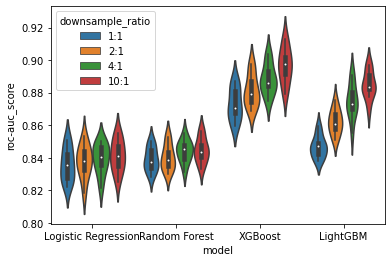

In [35]:
order = ['Logistic Regression','Random Forest','XGBoost','LightGBM']
sns.violinplot(data=df[df.set=='train'], x="model", y="roc-auc_score", hue="downsample_ratio", order=order)

<AxesSubplot:xlabel='model', ylabel='roc-auc_score'>

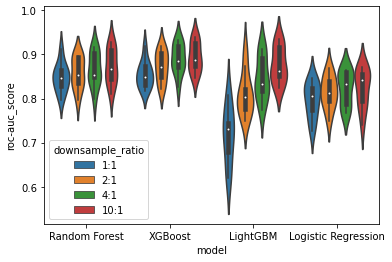

In [10]:
sns.violinplot(data=df[df.set=='test'], x="model", y="roc-auc_score", hue="downsample_ratio")

In [18]:
import glob
import cloudpickle
def get_data2(pat):
    path = parent + '/Capstone_project'
    cloudpickle_files = glob.glob(os.path.join(path, f"{pat}*.cloudpickle"))
    cloudpickle_files.sort()
    test_scores = pd.DataFrame()
    for cpk in cloudpickle_files:
        if cpk.split('/')[-1].split('.')[0].split('_')[0] == 'rf':
            model_lab = 'Random Forest'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'xgb':
            model_lab = 'XGBoost'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'lgbm':
            model_lab = 'LightGBM'
        elif cpk.split('/')[-1].split('.')[0].split('_')[0] == 'lgr':
            model_lab = 'Logistic Regression'
        if cpk.split('/')[-1].split('.')[0][-1] == '1':
            dsample_rat = '10:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '2':
            dsample_rat = '4:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '3':
            dsample_rat = '2:1'
        elif cpk.split('/')[-1].split('.')[0][-1] == '4':
            dsample_rat = '1:1'
            
        cpkpipe = cloudpickle.load(open(cpk, 'rb'))
        eval_score = roc_auc_score(test_y, cpkpipe.predict_proba(test_X)[:, 1])
        test_score = pd.DataFrame({'roc-auc_score': eval_score, 'model': model_lab, 'downsample_ratio':dsample_rat}, index=[0])
        test_scores = pd.concat([test_score, test_scores], axis=0)
    return test_scores

In [23]:
rf_test = get_data2("rf_pipe")
xgb_test = get_data2("xgb_pipe")
lgbm_test = get_data2("lgbm_pipe")
lgr_test = get_data2("lgr_pipe")

<AxesSubplot:xlabel='model', ylabel='roc-auc_score'>

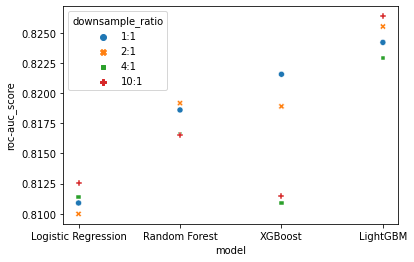

In [34]:
df_test = pd.concat([lgr_test,rf_test,xgb_test,lgbm_test], axis=0)
sns.scatterplot(data=df_test, x="model", y="roc-auc_score", hue="downsample_ratio", style="downsample_ratio")

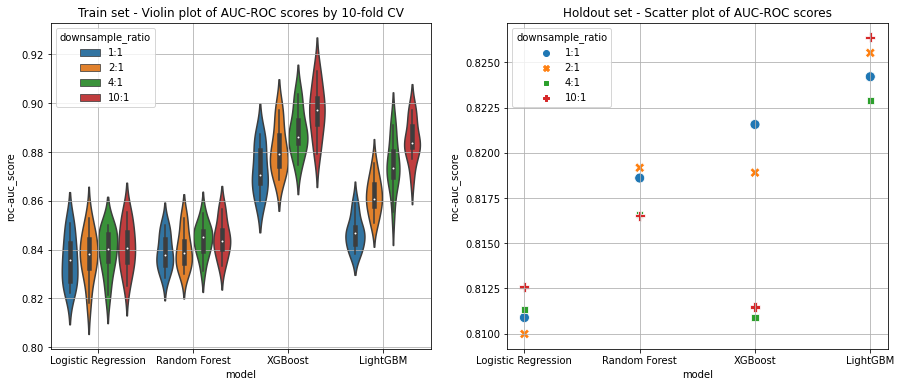

In [59]:
fig, axes = plt.subplots(1, 2,  figsize=(15,6))
axes[0].set_title('Train set - Violin plot of AUC-ROC scores by 10-fold CV')
axes[1].set_title('Holdout set - Scatter plot of AUC-ROC scores')

order = ['Logistic Regression','Random Forest','XGBoost','LightGBM']
sns.violinplot(data=df[df.set=='train'], x="model", y="roc-auc_score", hue="downsample_ratio", order=order, ax=axes[0])
sns.scatterplot(data=df_test, x="model", y="roc-auc_score", hue="downsample_ratio", style="downsample_ratio", ax=axes[1],s=100)
sns.move_legend(axes[0], "upper left")
axes[0].grid() 
axes[1].grid()
plt.show()